# Set-up

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import tensorflow.keras,os
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

import os
from os.path import join, isfile
from os import listdir
import cv2
import glob
from google.colab import drive

# Set the seed
seed = 1

In [0]:
tensorflow.__version__

'2.1.0'

In [0]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [0]:
drive.mount('/gdrive/')
# Prompted for Authentication

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [0]:
%cd /gdrive/My Drive/
#%cd /gdrive/My Drive/Matts/

/gdrive/My Drive


# Load the data

In [0]:
# Define folder name & count folders/classes
base_path = "data/Blood_Cancer_unfiltered/"
dir_list = listdir(base_path) # extract number of classes
print("Found classes: ",len(dir_list))

Found classes:  4


In [0]:
from natsort import natsorted, ns
n_classes = natsorted(dir_list, alg=ns.PATH | ns.IGNORECASE)
NUM_CLASSES = len(n_classes)

In [0]:
# Name of classes
n_classes

['AMLMo', 'AMLMy', 'BNHLclk', 'CMLmb']

In [0]:
# Count of all files
file_count = sum([len(files) for r, d, files in os.walk(base_path)])
print('Found files/images #:  ', file_count)

Found files/images #:   17474


In [0]:
# Files in Class - AMLMo
class_path_1 = "data/Blood_Cancer_unfiltered/AMLMo"
file_count_1 = sum([len(files) for r, d, files in os.walk(class_path_1)])
print('Found files/images #:  ', file_count_1)

Found files/images #:   1788


In [0]:
# Files in Class - AMLMy
class_path_2 = "data/Blood_Cancer_unfiltered/AMLMy"
file_count_2 = sum([len(files) for r, d, files in os.walk(class_path_2)])
print('Found files/images #:  ', file_count_2)

Found files/images #:   8483


In [0]:
# Files in Class - BNHLclk
class_path_3 = "data/Blood_Cancer_unfiltered/BNHLclk"
file_count_3 = sum([len(files) for r, d, files in os.walk(class_path_3)])
print('Found files/images #:  ', file_count_3)

Found files/images #:   3936


In [0]:
# Files in Class - CMLmb
class_path_4 = "data/Blood_Cancer_unfiltered/CMLmb"
file_count_4 = sum([len(files) for r, d, files in os.walk(class_path_4)])
print('Found files/images #:  ', file_count_4)

Found files/images #:   3267


In [0]:
directory = "data/Blood_Cancer_unfiltered"

trdata = ImageDataGenerator(validation_split=0.2)
traindata = trdata.flow_from_directory(directory=directory, subset='training', seed=seed, shuffle=True, target_size=(224,224))
tsdata = ImageDataGenerator(validation_split=0.2)
testdata = tsdata.flow_from_directory(directory=directory, subset='validation', seed=seed, shuffle=False, target_size=(224,224))

# AUGMENTATION CODE:
# trdata = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# tsdata = ImageDataGenerator(rescale=1./255)
# testdata = tsdata.flow_from_directory(
#         'data/validation',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 13981 images belonging to 4 classes.
Found 3493 images belonging to 4 classes.


In [0]:
# testdata[1]

In [0]:
## Labels for y_test
# y_test_label = tensorflow.keras.preprocessing.image.DirectoryIterator.labels.fget(self=testdata)[2500]
y_test_label = tensorflow.keras.preprocessing.image.DirectoryIterator.labels.fget(self=testdata)

In [0]:
y_test_label

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [0]:
## test_images
import IPython.display as display
import pathlib
data_dir = pathlib.Path(base_path)

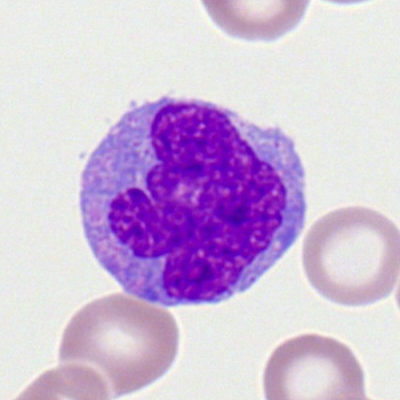

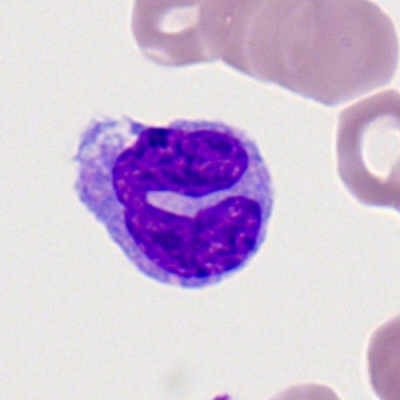

In [0]:
## Sample images from class [1]
AMLMo = list(data_dir.glob('AMLMo/*'))

for image_path in AMLMo[:2]:
    display.display(Image.open(str(image_path)))

# Define the model

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [0]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

# Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

## One-hot encoding

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. So we need a vector in size of number of classes as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of class numbers too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

one_hot_encode function takes the input, x, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. one_hot_encode function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

In [0]:
# ### CODE TO BE TESTED
# def one_hot_encode(x):
#     """
#         argument
#             - x: a list of labels
#         return
#             - one hot encoding matrix (number of labels, number of class)
#     """
#     encoded = np.zeros((len(x), NUM_CLASSES))
    
#     for idx, val in enumerate(x):
#         encoded[idx][val] = 1
    
#     return encoded

In [0]:
# ### one-hot encoding for labels (TO BE TRIED)
# labels = np_utils.to_categorical(labels)

## Set-up the layers

In [0]:
# Set-up the model (with partially pre-trained architecture)
# conv_base
vgg16 = VGG16(weights='imagenet')
# vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None)

In [0]:
## Dense Layers = with n classes as NUM_CLASSES
## Unfreezing some layers in order to train
## If model has been saved & you want to restart from a saved version, comment this section out
vgg16.summary()
x  = vgg16.get_layer('fc2').output
prediction = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-6:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Manually build layers

In [0]:
# model = Sequential()

In [0]:
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

In [0]:
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [0]:
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [0]:
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [0]:
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [0]:
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

In [0]:
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [0]:
# model.add(Flatten())

In [0]:
# model.add(Dense(units=4096,activation="relu"))

In [0]:
# model.add(Dense(units=4096,activation="relu"))

In [0]:
# model.add(Dense(units=2, activation="softmax"))

## Compile the model

In [0]:
# # Loading a previously saved model --> Uncomment this section
# from tensorflow.keras.models import load_model
# model = load_model("data/vgg16_cancer_1.h5")

In [0]:
# # Reset the data generators before prediction
# traindata.reset()
# testdata.reset()

In [0]:
# # Verifying the model has re-loaded correctly
# print(model.predict(testdata).shape)

(3493, 4)


In [0]:
## Configure the compiler
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Setting the parameters for Saving (Checkpoint, EarlyStopping)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("data/vgg16_cancer_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [0]:
## return a list of file names in 1 class
# os.listdir('data/Blood_Cancer_unfiltered/AMLMo') 

In [0]:
# Name & Order of classes
n_classes

['AMLMo', 'AMLMy', 'BNHLclk', 'CMLmb']

In [0]:
## Defining class weight for imbalanced dataset of images (TOTAL_SAMPLES / (NUM_CLASSES x CLASS_SAMPLE_SIZE))
class_weight_1 = round(file_count/(NUM_CLASSES * file_count_1),1)
class_weight_2 = round(file_count/(NUM_CLASSES * file_count_2),1)
class_weight_3 = round(file_count/(NUM_CLASSES * file_count_3),1)
class_weight_4 = round(file_count/(NUM_CLASSES * file_count_4),1)

In [0]:
# Checking to see the classes index number (sample)
n_classes.index("CMLmb")

3

In [0]:
print("Class Weight - AMLMo  : ", class_weight_1)
print("Class Weight - AMLMy  : ", class_weight_2)
print("Class Weight - BNHLclk: ", class_weight_3)
print("Class Weight - CMLmb  : ", class_weight_4)

Class Weight - AMLMo  :  2.4
Class Weight - AMLMy  :  0.5
Class Weight - BNHLclk:  1.1
Class Weight - CMLmb  :  1.3


In [0]:
## Setting the class weights in a dictionary - Ensure the class weights line up with the values above
# sample_weights = class_weight.compute_sample_weight('balanced', np.unique(n_classes))
class_weight =  {0 : 2.4 , 1 : 0.5 , 2 : 1.1 , 3 : 1.3}

# Train the model

Training the model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `traindata` arrays.
2. The model learns to associate images and labels.
3. Then we ask the model to make predictions about a test set—in this example, the `testdata` array.
4. Verify that the predictions match the labels from the `y_test_label` array.

## Feed the model

In [0]:
# hist = model.fit(generator=traindata,
#                  epochs=30,
#                  steps_per_epoch=100,
#                  batch_size=25,
#                  validation_data=testdata,
#                  validation_steps=10,
#                  callbacks=[checkpoint,early])

hist = model.fit(traindata,
                 epochs=30,
                 steps_per_epoch=10,
                 validation_data=testdata,
                 validation_steps=10,
                 callbacks=[checkpoint,early],
                 class_weight=class_weight
                 )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/30
 9/10 [==========================>...] - ETA: 20s - loss: 4.4101 - acc: 0.3229
Epoch 00001: val_acc improved from -inf to 0.00313, saving model to data/vgg16_cancer_1.h5
10/10 [==============================] - 212s 21s/step - loss: 4.0534 - acc: 0.3594 - val_loss: 7.2742 - val_acc: 0.0031
Epoch 2/30
 9/10 [==========================>...] - ETA: 21s - loss: 0.9860 - acc: 0.6181
Epoch 00002: val_acc improved from 0.00313 to 0.66562, saving model to data/vgg16_cancer_1.h5
10/10 [==============================] - 227s 23s/step - loss: 0.9379 - acc: 0.6344 - val_loss: 2.2939 - val_acc: 0.6656
Epoch 3/30
 9/10 [==========================>...] - ETA: 21s - loss: 0.7605 - acc: 0.7847
Epoch 00003: val_acc improved from 0.66562 to 0.89062, saving model to data/vgg16_cancer_1.h5
10/10 [==============================] - 226s 23s/step - loss: 0.7278 - acc: 0.7750 - val_loss: 0.6737 - val_acc: 0.8

In [0]:
## Save the entire model to a HDF5 file
model.save('data/vgg16_cancer_1.h5')

In [0]:
## Save the weights of the model
model.save_weights('data/vgg16_cancer_weights_1.h5')

## Evaluate accuracy

In [0]:
# Print the "val_acc" metrics gathered throughout the train_test
print(hist.history['val_acc'])

In [0]:
## What metrics are being used while training the model?
print('Metrics used while training the model:')
for key in hist.history:
  print(key)
print('\naccuracy:')
print(hist.history['acc'])
print('\nhistory dictionary:')
print(hist.history)

Metrics used while training the model:
loss
acc
val_loss
val_acc

accuracy:
[0.359375, 0.634375, 0.775, 0.853125, 0.853125, 0.903125, 0.903125, 0.865625, 0.90625, 0.915625, 0.925, 0.85625, 0.884375, 0.9625, 0.9375, 0.9, 0.946875, 0.925, 0.915625, 0.925, 0.91875, 0.896875, 0.903125, 0.928125, 0.953125, 0.9463722, 0.946875, 0.9375, 0.9625, 0.928125]

history dictionary:
{'loss': [4.053435790538788, 0.9378820598125458, 0.7278331309556961, 0.5639274820685387, 0.42050029188394544, 0.3601264163851738, 0.34664895981550214, 0.4849980354309082, 0.2914615757763386, 0.2515269123017788, 0.33841267973184586, 0.4082659214735031, 0.31790358647704126, 0.11384857539087534, 0.24653524757595732, 0.38010652661323546, 0.3585503090173006, 0.26117696296423676, 0.25308197513222697, 0.27733459509909153, 0.2559032065793872, 0.282884044200182, 0.38008669801056383, 0.2612738966941833, 0.2268559791147709, 0.24812375455624675, 0.18379070591181518, 0.24028832018375396, 0.13689072635024785, 0.31961768995970485], 'acc

In [0]:
## Code to save history (metrics)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = 'data/vgg16_cancer_1_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## or save to csv: 
# hist_csv_file = 'data/history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

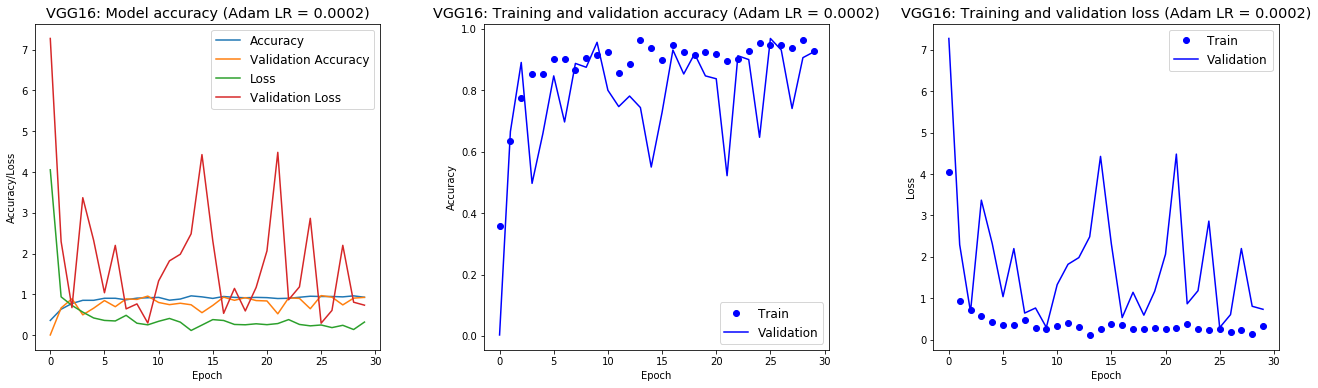

In [0]:
# Plot the metrics from training the model

accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)

plt.rcParams.update({'font.size': 12})

# Plot combined accuracy & loss values
ax[0].plot(epochs, accuracy)
ax[0].plot(epochs, val_accuracy)
ax[0].plot(epochs, loss)
ax[0].plot(epochs, val_loss)
ax[0].set_title('VGG16: Model accuracy (Adam LR = 0.0002)')
ax[0].set_ylabel('Accuracy/Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

# Plot training & validation accuracy values
ax[1].plot(epochs, accuracy, 'bo', label='Training acc')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation acc')
ax[1].set_title('VGG16: Training and validation accuracy (Adam LR = 0.0002)')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

# Plot training & validation loss values
ax[2].plot(epochs, loss, 'bo', label='Training loss')
ax[2].plot(epochs, val_loss, 'b', label='Validation loss')
ax[2].set_title('VGG16: Training and validation loss (Adam LR = 0.0002)')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Train', 'Validation'])

plt.show()

In [0]:
# Evaluate the overall accuracy of the model
score = model.evaluate(testdata, verbose=2)
print('\nOverall model accuracy:')
print('\nTest loss: %.4f, Test accuracy: %.4f' % tuple(score))

  ...
    to  
  ['...']
110/110 - 13s - loss: 0.2934 - acc: 0.9124

Overall model accuracy:

Test loss: 0.2934, Test accuracy: 0.9124


## Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the logits (model's linear outputs) to probabilities, which are easier to interpret.

In [0]:
# Loading a previously saved model - Load again with "new" name
# includes its weights and the optimizer (i.e. loading the h5 file)  
new_model = load_model('data/vgg16_cancer_1.h5')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
## Reset the data generators before prediction
traindata.reset()
testdata.reset()

In [0]:
# # Validating the model is loaded correctly
# print(model.predict(testdata).shape)
print(new_model.predict(testdata).shape)

(3493, 4)


In [0]:
# Evaluate the restored model
loss, acc = new_model.evaluate(testdata, verbose=2)
print('Restored model - accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(testdata).shape)

  ...
    to  
  ['...']
110/110 - 13s - loss: 0.2934 - acc: 0.9124
Restored model - accuracy: 91.24%
(3493, 4)


In [0]:
## Load the restored model with Softmax layer
probability_model = tensorflow.keras.Sequential([new_model,
                                                 tensorflow.keras.layers.Softmax()])

**Make a prediction on a random index number from the test data**

In [0]:
model_predictions = probability_model.predict(testdata)

In [0]:
model_predictions[1500]

array([0.17487772, 0.47536692, 0.17487772, 0.17487772], dtype=float32)

In [0]:
# What class is being predicted?
np.argmax(model_predictions[1500])

1

In [0]:
# Verifying against the test label
y_test_label[1500]

1

In [0]:
# Which class is this
n_classes[1]

'AMLMy'

**Plotting a Confusion Matrix**

In [0]:
# y_test_label

In [0]:
Y_pred = model_predictions
Y_pred

array([[0.47535545, 0.17488232, 0.17488085, 0.1748814 ],
       [0.44710633, 0.17917323, 0.19357708, 0.18014336],
       [0.47463426, 0.17533995, 0.17500173, 0.17502397],
       ...,
       [0.47485834, 0.17496066, 0.17495948, 0.17522155],
       [0.18514054, 0.17735945, 0.17745888, 0.46004117],
       [0.17490953, 0.17491096, 0.17491113, 0.47526833]], dtype=float32)

In [0]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix:')
print(confusion_matrix(testdata.classes, y_pred))

Confusion Matrix:
[[ 332    1    1   23]
 [  95 1590    7    4]
 [  51    5  641   90]
 [  28    0    1  624]]


In [0]:
print('Classification Report')
target_names = list(traindata.class_indices.keys())
target_names

Classification Report


['AMLMo', 'AMLMy', 'BNHLclk', 'CMLmb']

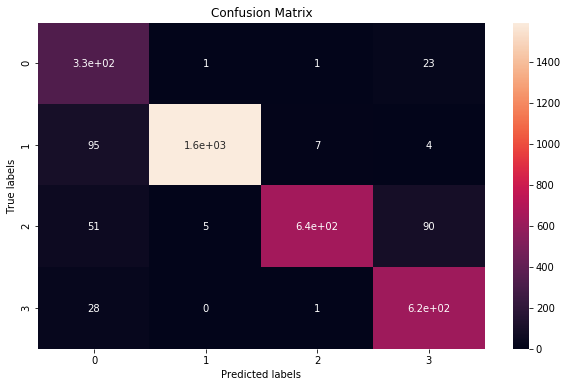

In [0]:
## Plotting Confusion Matrix
labels = target_names
cm = confusion_matrix(testdata.classes, y_pred)

f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [0]:
print(classification_report(testdata.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       AMLMo       0.66      0.93      0.77       357
       AMLMy       1.00      0.94      0.97      1696
     BNHLclk       0.99      0.81      0.89       787
       CMLmb       0.84      0.96      0.90       653

    accuracy                           0.91      3493
   macro avg       0.87      0.91      0.88      3493
weighted avg       0.93      0.91      0.92      3493



In [0]:
# f1 Score
print('f1-score:     {:5.2f}%'.format(100*f1_score(testdata.classes,y_pred, average='weighted')))

f1-score:     91.60%


**Generate Graph/Plot to look at the full set of "n_class" predictions**

In [0]:
# def plot_image(i, predictions_array, true_label, img):
#   predictions_array, true_label, img = predictions_array, true_label[i], img[i]
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)

#   predicted_label = np.argmax(predictions_array)
#   if predicted_label == true_label:
#     color = 'blue'
#   else:
#     color = 'red'

#   plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 class_names[true_label]),
#                                 color=color)

In [0]:
# def plot_value_array(i, predictions_array, true_label):
#   predictions_array, true_label = predictions_array, true_label[i]
#   plt.grid(False)
#   plt.xticks(range(10))
#   plt.yticks([])
#   thisplot = plt.bar(range(10), predictions_array, color="#777777")
#   plt.ylim([0, 1])
#   predicted_label = np.argmax(predictions_array)

#   thisplot[predicted_label].set_color('red')
#   thisplot[true_label].set_color('blue')

## Verify predictions

In [0]:
## Load saved model - don't load again if already loaded the "new" model above
# saved_model = load_model("vgg16_cancer_1.h5")

In [0]:
## Run prediction samples - don't run again if already loaded the "new" model above
# predictions = saved_model.predict(testdata, max_queue_size=10, workers=1)

In [0]:
## Load images from the Prediction folder
from google.colab.patches import cv2_imshow
#select the path
path = "data/Prediction/*.*"
for file in glob.glob(path):
  print(file)
a = cv2.imread(file)
# print(a)

data/Prediction/MON_1250.tiff
data/Prediction/NGS_8000.tiff
data/Prediction/MYO_3250.tiff
data/Prediction/LYT_3500.tiff


In [0]:
## Setting up a true label dictionary
# True class labels:
# ['AMLMo', 'AMLMy', 'BNHLclk', 'CMLmb']
# ['MON', 'NGS', 'LYT', 'MYO']
# [0, 1, 2, 3]

true_label_testing =  {'MON' : 0 , 'NGS' : 1 , 'LYT' : 2 , 'MYO' : 3 }

**Single image prediction**

Çlass probabilities:
[[0.01236669 0.01285138 0.9601268  0.01465501]]


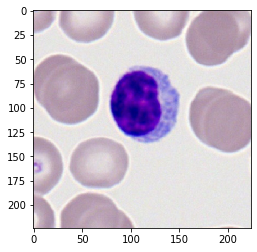

In [0]:
# img_path = 'data/Prediction/MON_1250.tiff'
# img_path = 'data/Prediction/NGS_8000.tiff'
# img_path = 'data/Prediction/MYO_3250.tiff'
img_path = 'data/Prediction/LYT_3500.tiff'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

print('Çlass probabilities:')
Image_Prediction = new_model.predict(img_data)
print(Image_Prediction)

plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [0]:
# Predicted Class
print("Predicted label/class:     ", np.argmax(Image_Prediction))

Predicted label/class:      2


In [0]:
# Classname from the file path
split_path = os.path.split(img_path)
# Get first 3 characters of filename as class
class_name = split_path[1][0:3]
# class_name

# True label from dictionary:
i = true_label_testing 
print('True label/class:     ',i[class_name])

True label/class:      2


# Use the trained model

As the total dataset is split into training and validation (not training, validation and test), there is no need to run the model again against a test dataset as it would be redundant and using the same validation dataset.

**END**